In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np

df = pd.read_csv("../eval/results.csv")

# Fix types
df["faithfulness"] = pd.to_numeric(df["faithfulness"], errors="coerce")
df["abstained"] = df["abstained"].astype(str).str.lower() == "true"

drift_labels = {
    0: "Base",
    1: "Paraphrase",
    2: "Scope\nChange",
    3: "Entity\nSwap",
    4: "Negation"
}

print(df.groupby(["variant", "drift_level"])["faithfulness"].mean().round(3))

variant   drift_level
baseline  0                NaN
          1                NaN
          2                NaN
          3                NaN
          4                NaN
full      0              0.967
          1              0.900
          2              0.900
          3              0.267
          4              0.000
hybrid    0                NaN
          1                NaN
          2                NaN
          3                NaN
          4                NaN
Name: faithfulness, dtype: float64


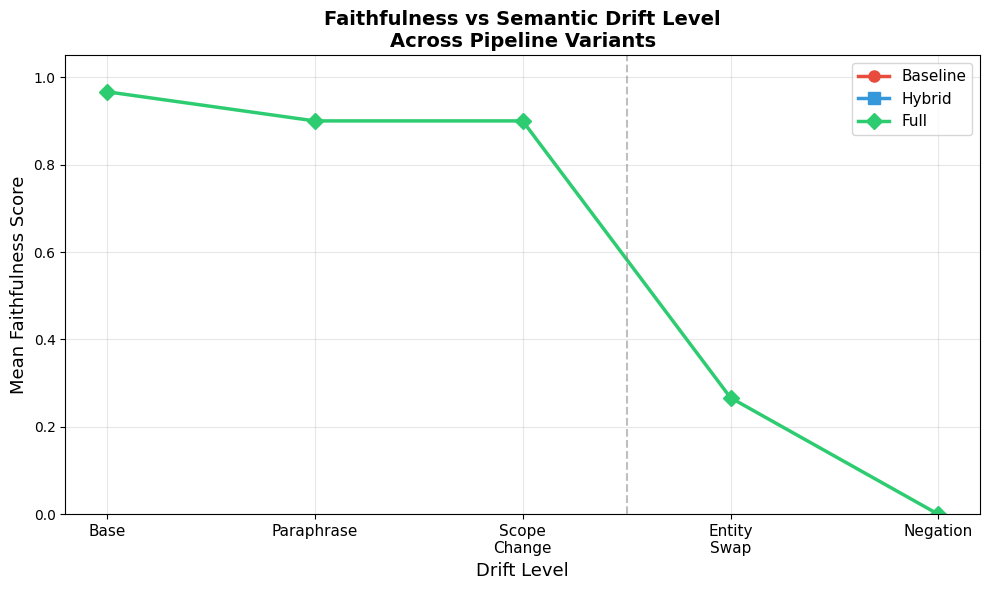

Saved: eval/faithfulness_vs_drift.png


In [2]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {"baseline": "#e74c3c", "hybrid": "#3498db", "full": "#2ecc71"}
markers = {"baseline": "o", "hybrid": "s", "full": "D"}

for variant in ["baseline", "hybrid", "full"]:
    sub = df[df["variant"] == variant].groupby("drift_level")["faithfulness"].mean()
    ax.plot(
        sub.index,
        sub.values,
        label=variant.capitalize(),
        color=colors[variant],
        marker=markers[variant],
        linewidth=2.5,
        markersize=8,
    )

ax.set_xticks(list(drift_labels.keys()))
ax.set_xticklabels(list(drift_labels.values()), fontsize=11)
ax.set_xlabel("Drift Level", fontsize=13)
ax.set_ylabel("Mean Faithfulness Score", fontsize=13)
ax.set_title("Faithfulness vs Semantic Drift Level\nAcross Pipeline Variants", fontsize=14, fontweight="bold")
ax.set_ylim(0, 1.05)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.axvline(x=2.5, color="gray", linestyle="--", alpha=0.5, label="Drift threshold")

plt.tight_layout()
plt.savefig("../eval/faithfulness_vs_drift.png", dpi=150)
plt.show()
print("Saved: eval/faithfulness_vs_drift.png")

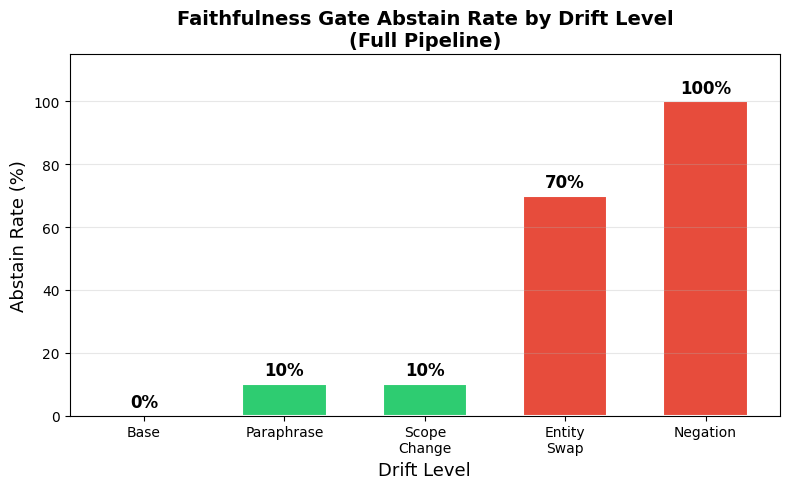

Saved: eval/abstain_rate_by_drift.png


In [3]:
fig, ax = plt.subplots(figsize=(8, 5))

full_df = df[df["variant"] == "full"].copy()
abstain_rate = full_df.groupby("drift_level")["abstained"].mean() * 100

bars = ax.bar(
    [drift_labels[i] for i in abstain_rate.index],
    abstain_rate.values,
    color=["#2ecc71" if v < 30 else "#e67e22" if v < 70 else "#e74c3c" for v in abstain_rate.values],
    edgecolor="white",
    linewidth=1.5,
    width=0.6,
)

for bar, val in zip(bars, abstain_rate.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1.5,
        f"{val:.0f}%",
        ha="center", va="bottom", fontsize=12, fontweight="bold"
    )

ax.set_xlabel("Drift Level", fontsize=13)
ax.set_ylabel("Abstain Rate (%)", fontsize=13)
ax.set_title("Faithfulness Gate Abstain Rate by Drift Level\n(Full Pipeline)", fontsize=14, fontweight="bold")
ax.set_ylim(0, 115)
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.savefig("../eval/abstain_rate_by_drift.png", dpi=150)
plt.show()
print("Saved: eval/abstain_rate_by_drift.png")

/opt/anaconda3/envs/rl_gymn/lib/python3.9/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/anaconda3/envs/rl_gymn/lib/python3.9/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/anaconda3/envs/rl_gymn/lib/python3.9/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/anaconda3/envs/rl_gymn/lib/python3.9/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim

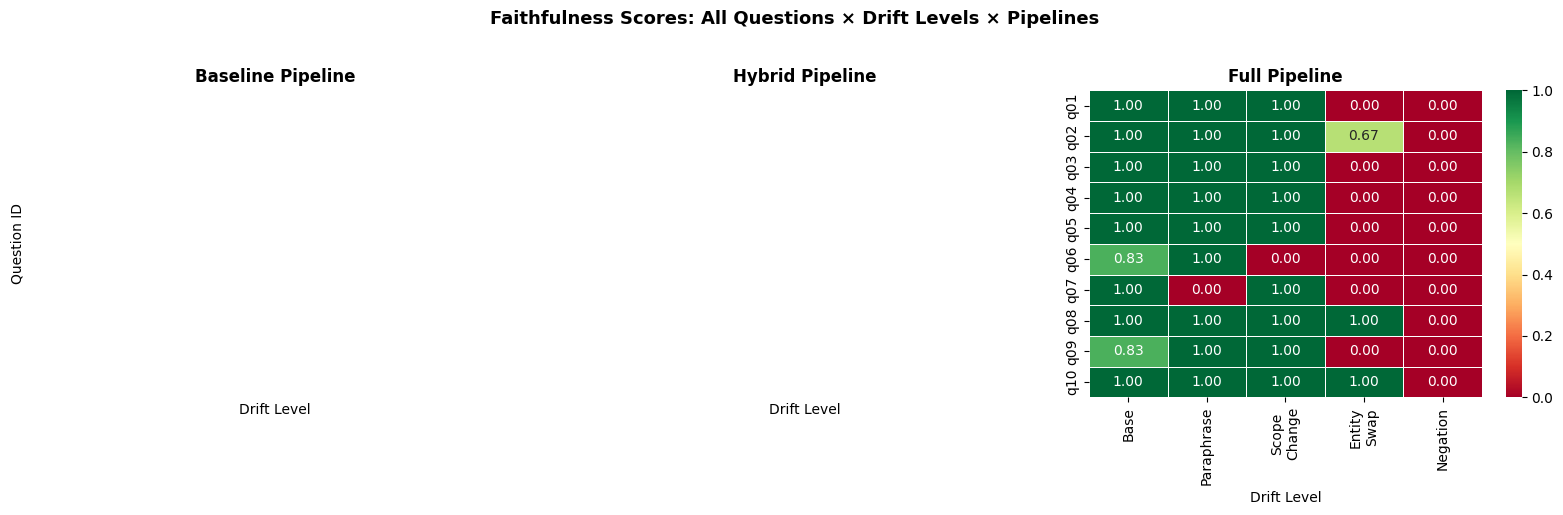

Saved: eval/faithfulness_heatmap.png


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, variant in zip(axes, ["baseline", "hybrid", "full"]):
    pivot = df[df["variant"] == variant].pivot_table(
        index="question_id",
        columns="drift_level",
        values="faithfulness",
        aggfunc="mean"
    )
    pivot.columns = [drift_labels[c] for c in pivot.columns]

    sns.heatmap(
        pivot,
        ax=ax,
        cmap="RdYlGn",
        vmin=0, vmax=1,
        annot=True, fmt=".2f",
        linewidths=0.5,
        cbar=(ax == axes[-1]),
    )
    ax.set_title(f"{variant.capitalize()} Pipeline", fontsize=12, fontweight="bold")
    ax.set_xlabel("Drift Level")
    ax.set_ylabel("Question ID" if ax == axes[0] else "")

plt.suptitle("Faithfulness Scores: All Questions × Drift Levels × Pipelines", 
             fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("../eval/faithfulness_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: eval/faithfulness_heatmap.png")

In [6]:
print("=" * 55)
print("KEY FINDINGS SUMMARY")
print("=" * 55)

# Full pipeline faithfulness by drift
full = df[df["variant"] == "full"]
by_drift = full.groupby("drift_level")["faithfulness"].mean()

print("\nFULL PIPELINE — Faithfulness by drift level:")
for level, score in by_drift.items():
    from_labels = {0:"Base", 1:"Paraphrase", 2:"Scope Change", 3:"Entity Swap", 4:"Negation"}
    print(f"  {from_labels[level]:<15}: {score:.3f}")

print(f"\nFaithfulness drop (base → negation): {by_drift[0] - by_drift[4]:.3f}")
print(f"Sharpest drop between: Scope Change → Entity Swap ({by_drift[2]:.3f} → {by_drift[3]:.3f})")

print("\nFULL PIPELINE — Abstain analysis:")
print(f"  Total abstains: {full['abstained'].sum()} / {len(full)} ({full['abstained'].mean():.0%})")
for level in range(5):
    rate = full[full["drift_level"]==level]["abstained"].mean()
    print(f"  Drift {level} abstain rate: {rate:.0%}")

print("\nNOTE: Baseline and Hybrid pipelines do not compute")
print("faithfulness scores — they have no gate.")
print("The faithfulness scorer is exclusive to the Full pipeline.")

KEY FINDINGS SUMMARY

FULL PIPELINE — Faithfulness by drift level:
  Base           : 0.967
  Paraphrase     : 0.900
  Scope Change   : 0.900
  Entity Swap    : 0.267
  Negation       : 0.000

Faithfulness drop (base → negation): 0.967
Sharpest drop between: Scope Change → Entity Swap (0.900 → 0.267)

FULL PIPELINE — Abstain analysis:
  Total abstains: 19 / 50 (38%)
  Drift 0 abstain rate: 0%
  Drift 1 abstain rate: 10%
  Drift 2 abstain rate: 10%
  Drift 3 abstain rate: 70%
  Drift 4 abstain rate: 100%

NOTE: Baseline and Hybrid pipelines do not compute
faithfulness scores — they have no gate.
The faithfulness scorer is exclusive to the Full pipeline.
